In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [3]:
class basic_block(nn.Module):
    # 輸出通道乘的倍數
    expansion = 1

    def __init__(self, in_channels, out_channels, stride, downsample):
        super(basic_block, self).__init__()      
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 在 shortcut 時，若維度不一樣，要更改維度
        self.downsample = downsample 


    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [25]:
class bottleneck_block(nn.Module):
    # 輸出通道乘的倍數
    expansion = 4

    def __init__(self, in_channels, out_channels, stride, downsample):
        super(bottleneck_block, self).__init__()      
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        # 在 shortcut 時，若維度不一樣，要更改維度
        self.downsample = downsample 


    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [13]:
class ResNet(nn.Module):
    def __init__(self, net_block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.net_block_layer(net_block, 64, layers[0])
        self.layer2 = self.net_block_layer(net_block, 128, layers[1], stride=2)
        self.layer3 = self.net_block_layer(net_block, 256, layers[2], stride=2)
        self.layer4 = self.net_block_layer(net_block, 512, layers[3], stride=2)

        self.avgpooling = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * net_block.expansion, num_classes)

        # 參數初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

            elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)        

    def net_block_layer(self, net_block, out_channels, num_blocks, stride=1):
        downsample = None

      # 在 shortcut 時，若維度不一樣，要更改維度
        if stride != 1 or self.in_channels != out_channels * net_block.expansion:
        downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels * net_block.expansion, kernel_size=1, stride=stride, bias=False),
                      nn.BatchNorm2d(out_channels * net_block.expansion))

        layers = []
        layers.append(net_block(self.in_channels, out_channels, stride, downsample))
        if net_block.expansion != 1:
        self.in_channels = out_channels * net_block.expansion

        else:
        self.in_channels = out_channels

        for i in range(1, num_blocks):
        layers.append(net_block(self.in_channels, out_channels, 1, None))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpooling(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpooling(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)

        return x

In [14]:
# Parameters
batch_size = 64
num_epochs = 5
lr = 0.001

num_classes=2

# ResNet18
model = ResNet(basic_block, [2, 2, 2, 2], num_classes)

if CUDA:
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [6]:
import json
import zipfile
import os

# kaggle api
api_token = {"username":"aaa","key":"kkk"}
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle datasets download -d chetankv/dogs-cats-images --force
 
!ls /kaggle

 98% 425M/435M [00:13<00:00, 20.5MB/s]
100% 435M/435M [00:13<00:00, 33.3MB/s]
dogs-cats-images.zip


In [7]:
!unzip dogs-cats-images.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3711.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3712.jpg  
  infl

In [15]:
# Transform
transform = transforms.Compose(
                [transforms.Resize(size=(227,227)),
                 transforms.CenterCrop(224),
                 transforms.RandomRotation(20),
                  transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),]
                )

# Data
train_dataset = datasets.ImageFolder(root='/kaggle/dataset/training_set', transform=transform)
valid_dataset = datasets.ImageFolder(root='/kaggle/dataset/test_set', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [17]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    total_train = 0
    correct_train = 0
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        # clear gradient
        optimizer.zero_grad()

        # Forward propagation
        output = model(data) 
        loss = criterion(output, target) 

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        total_train += len(target)
        correct_train += sum((predicted == target).float())
        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Train Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, num_epochs, batch_idx+1, len(train_loader),
               correct_train / float((batch_idx + 1) * batch_size),
               train_loss / float((batch_idx + 1) * batch_size)))
            
    train_acc_ = 100 * (correct_train / float(total_train))
    train_loss_ = train_loss / total_train
                    
    return train_acc_, train_loss_

In [18]:
def validate(valid_loader, model, criterion, epoch): 
    model.eval()
    total_valid = 0
    correct_valid = 0
    valid_loss = 0
    
    for batch_idx, (data, target) in enumerate(valid_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target) 

        predicted = torch.max(output.data, 1)[1]
        total_valid += len(target)
        correct_valid += sum((predicted == target).float())
        valid_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Valid Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, num_epochs, batch_idx+1, len(valid_loader),
               correct_valid / float((batch_idx + 1) * batch_size),
               valid_loss / float((batch_idx + 1) * batch_size)))
            
    valid_acc_ = 100 * (correct_valid / float(total_valid))
    valid_loss_ = valid_loss / total_valid
                    
    return valid_acc_, valid_loss_

In [19]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader):
    # set objects for storing metrics
    total_train_loss = []
    total_valid_loss = []
    total_train_accuracy = []
    total_valid_accuracy = []
 
    # Train model
    for epoch in range(num_epochs):
        # training
        train_acc_, train_loss_ = train(train_loader, model, criterion, optimizer, epoch)
        total_train_loss.append(train_loss_)
        total_train_accuracy.append(train_acc_)

        # validation
        with torch.no_grad():
            valid_acc_, valid_loss_ = validate(valid_loader, model, criterion, epoch)
            total_valid_loss.append(valid_loss_)
            total_valid_accuracy.append(valid_acc_)

        print('==========================================================================')
        print("Epoch: {}/{}， Train acc： {:.6f}， Train loss： {:.6f}， Valid acc： {:.6f}， Valid loss： {:.6f}".format(
               epoch+1, num_epochs, 
               train_acc_, train_loss_,
               valid_acc_, valid_loss_))
        print('==========================================================================')

    print("====== END ==========")

    return total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy

In [20]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop(model, criterion, optimizer, train_loader, valid_loader)

Train Epoch: 1/5 [iter： 1/125], acc： 0.515625, loss： 0.011298
Train Epoch: 1/5 [iter： 101/125], acc： 0.597772, loss： 0.010919
Valid Epoch: 1/5 [iter： 1/32], acc： 0.125000, loss： 0.029005
Epoch: 1/5， Train acc： 60.924999， Train loss： 0.010670， Valid acc： 51.950001， Valid loss： 0.017593
Train Epoch: 2/5 [iter： 1/125], acc： 0.687500, loss： 0.009450
Train Epoch: 2/5 [iter： 101/125], acc： 0.675433, loss： 0.009418
Valid Epoch: 2/5 [iter： 1/32], acc： 0.640625, loss： 0.011873
Epoch: 2/5， Train acc： 68.387505， Train loss： 0.009314， Valid acc： 62.250000， Valid loss： 0.011296
Train Epoch: 3/5 [iter： 1/125], acc： 0.625000, loss： 0.010355
Train Epoch: 3/5 [iter： 101/125], acc： 0.696937, loss： 0.009036
Valid Epoch: 3/5 [iter： 1/32], acc： 0.937500, loss： 0.003273
Epoch: 3/5， Train acc： 70.237503， Train loss： 0.008951， Valid acc： 62.000000， Valid loss： 0.012578
Train Epoch: 4/5 [iter： 1/125], acc： 0.703125, loss： 0.008450
Train Epoch: 4/5 [iter： 101/125], acc： 0.718441, loss： 0.008415
Valid Epoch: 4/5

In [21]:
def plot_result(total_train, total_valid, label):
    plt.plot(range(num_epochs), total_train, 'b-', label=f'Training_{label}')
    plt.plot(range(num_epochs), total_valid, 'g-', label=f'validation_{label}')
    plt.title(f'Training & Validation {label}')
    plt.xlabel('Number of epochs')
    plt.ylabel(f'{label}')
    plt.legend()
    plt.show()

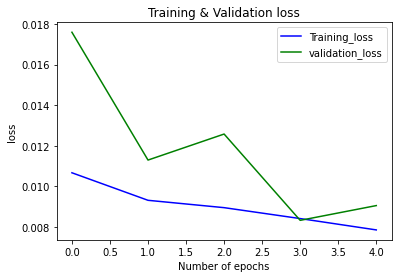

In [22]:
plot_result(total_train_loss, total_valid_loss, 'loss')

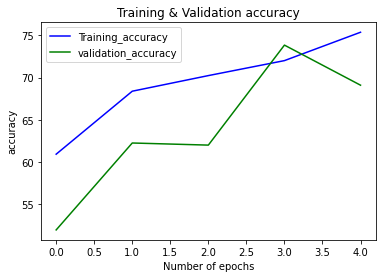

In [23]:
plot_result(total_train_accuracy, total_valid_accuracy, 'accuracy')

In [26]:
# Parameters
batch_size = 64
num_epochs = 5
lr = 0.001

num_classes=2

# ResNet50
model = ResNet(bottleneck_block, [3, 4, 6, 3], num_classes)

if CUDA:
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [27]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop(model, criterion, optimizer, train_loader, valid_loader)

Train Epoch: 1/5 [iter： 1/125], acc： 0.421875, loss： 0.016597
Train Epoch: 1/5 [iter： 101/125], acc： 0.594833, loss： 0.011785
Valid Epoch: 1/5 [iter： 1/32], acc： 0.484375, loss： 0.012828
Epoch: 1/5， Train acc： 59.475006， Train loss： 0.011482， Valid acc： 60.700005， Valid loss： 0.010373
Train Epoch: 2/5 [iter： 1/125], acc： 0.625000, loss： 0.010067
Train Epoch: 2/5 [iter： 101/125], acc： 0.660118, loss： 0.009685
Valid Epoch: 2/5 [iter： 1/32], acc： 0.734375, loss： 0.009672
Epoch: 2/5， Train acc： 66.362503， Train loss： 0.009682， Valid acc： 66.900002， Valid loss： 0.010487
Train Epoch: 3/5 [iter： 1/125], acc： 0.640625, loss： 0.010332
Train Epoch: 3/5 [iter： 101/125], acc： 0.684251, loss： 0.009314
Valid Epoch: 3/5 [iter： 1/32], acc： 0.859375, loss： 0.007009
Epoch: 3/5， Train acc： 68.800003， Train loss： 0.009262， Valid acc： 67.400002， Valid loss： 0.009902
Train Epoch: 4/5 [iter： 1/125], acc： 0.656250, loss： 0.009485
Train Epoch: 4/5 [iter： 101/125], acc： 0.715037, loss： 0.008760
Valid Epoch: 4/5

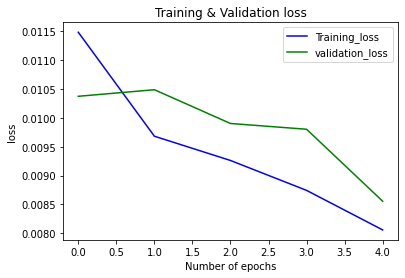

In [28]:
plot_result(total_train_loss, total_valid_loss, 'loss')

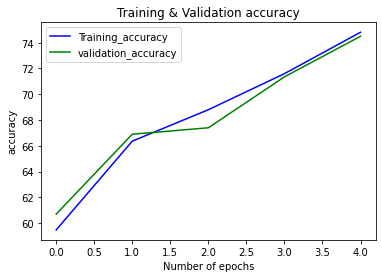

In [29]:
plot_result(total_train_accuracy, total_valid_accuracy, 'accuracy')

In [32]:
def ResNet_n(num_layers):
    if num_layers == 18:
        # ResNet18
        model = ResNet(basic_block, [2, 2, 2, 2], num_classes)

    elif num_layers == 34:
        # ResNet34
        model = ResNet(basic_block, [3, 4, 6, 3], num_classes)

    elif num_layers == 50:
        # ResNet50
        model = ResNet(bottleneck_block, [3, 4, 6, 3], num_classes)

    elif num_layers == 101:
        # ResNet101
        model = ResNet(bottleneck_block, [3, 4, 23, 3], num_classes)

    elif num_layers == 152:
        # ResNet152
        model = ResNet(bottleneck_block, [3, 8, 36, 3], num_classes)

    else:
        print("error")

        return

    return model


In [33]:
# Parameters
batch_size = 64
num_epochs = 5
lr = 0.001

num_classes=2

# ResNet34
model = ResNet_n(34)

if CUDA:
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [34]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop(model, criterion, optimizer, train_loader, valid_loader)

Train Epoch: 1/5 [iter： 1/125], acc： 0.531250, loss： 0.010653
Train Epoch: 1/5 [iter： 101/125], acc： 0.563892, loss： 0.011822
Valid Epoch: 1/5 [iter： 1/32], acc： 0.953125, loss： 0.003609
Epoch: 1/5， Train acc： 57.300003， Train loss： 0.011536， Valid acc： 55.550003， Valid loss： 0.014159
Train Epoch: 2/5 [iter： 1/125], acc： 0.671875, loss： 0.009670
Train Epoch: 2/5 [iter： 101/125], acc： 0.640006, loss： 0.010091
Valid Epoch: 2/5 [iter： 1/32], acc： 0.734375, loss： 0.009817
Epoch: 2/5， Train acc： 64.300003， Train loss： 0.010052， Valid acc： 66.349998， Valid loss： 0.009948
Train Epoch: 3/5 [iter： 1/125], acc： 0.781250, loss： 0.008387
Train Epoch: 3/5 [iter： 101/125], acc： 0.674196, loss： 0.009448
Valid Epoch: 3/5 [iter： 1/32], acc： 0.703125, loss： 0.008293
Epoch: 3/5， Train acc： 67.500000， Train loss： 0.009422， Valid acc： 69.650002， Valid loss： 0.009563
Train Epoch: 4/5 [iter： 1/125], acc： 0.765625, loss： 0.008456
Train Epoch: 4/5 [iter： 101/125], acc： 0.707611, loss： 0.008832
Valid Epoch: 4/5